# Whole image quality control metric evaluation

In this notebook, we will use the outputted QC metrics to start working on developing thresholds using z-score to flag and skip images during CellProfiler illumination correction. We are evaluating plates 3-5 to find generalizable metrics and thresholds for this dataset.

**Blur metric to detect out of focus images** -> PowerLogLogSlope

**Saturation metric to detect large smudges** -> PercentMaximal

## Import libraries

In [1]:
import pathlib
import pandas as pd
import numpy as np

from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

## Set paths and load in data frame

In [2]:
# Directory for figures to be outputted
figure_dir = pathlib.Path("./qc_figures")
figure_dir.mkdir(exist_ok=True)

# Directory with QC CellProfiler output per plate
qc_dir = pathlib.Path("./qc_results")

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

# List all plates
plates = ["Plate_3", "Plate_3_prime", "Plate_4", "Plate_5"]

# Loop through each plate
for plate in plates:
    # Read in CSV with all image quality metrics per image for the current plate
    qc_df = pd.read_csv(pathlib.Path(qc_dir / plate / "Image.csv"))

    # Adding 'Metadata_Well' and 'Metadata_Site' columns using filename from FileName_OrigActin (same for all channels)
    qc_df["Metadata_Well"] = qc_df["FileName_OrigRFP"].str.split("_").str[0]
    qc_df["Metadata_Site"] = qc_df["FileName_OrigRFP"].str.split("_").str[3]

    # Create a global variable with each plate as a data frame
    globals()[f"{plate}_df"] = qc_df

    # Store the data frame for the current plate in the dictionary
    all_qc_data_frames[plate] = qc_df

# view the dictionary to assess that all info is added correctly
print(all_qc_data_frames.keys())

# assess that the data frames per plate have correct number of image sets
print(Plate_5_df.shape)
Plate_5_df.head()

dict_keys(['Plate_3', 'Plate_3_prime', 'Plate_4', 'Plate_5'])
(1512, 87)


,Channel_OrigCY5,Channel_OrigDAPI,Channel_OrigGFP,Channel_OrigRFP,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05MeasureImageQuality,FileName_OrigCY5,...,URL_OrigCY5,URL_OrigDAPI,URL_OrigGFP,URL_OrigRFP,Width_OrigCY5,Width_OrigDAPI,Width_OrigGFP,Width_OrigRFP,Metadata_Well,Metadata_Site
0,-1,-1,-1,-1,0.0,0.0,1.18,0.0,1.76,B10_01_3_10_CY5_001.tif,...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,1224,1224,1224,1224,B10,10
1,-1,-1,-1,-1,0.0,0.0,1.11,0.0,1.62,B10_01_3_11_CY5_001.tif,...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,1224,1224,1224,1224,B10,11
2,-1,-1,-1,-1,0.0,0.0,0.73,0.0,1.41,B10_01_3_12_CY5_001.tif,...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,1224,1224,1224,1224,B10,12
3,-1,-1,-1,-1,0.0,0.0,0.46,0.0,1.58,B10_01_3_13_CY5_001.tif,...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,1224,1224,1224,1224,B10,13
4,-1,-1,-1,-1,0.0,0.0,0.54,0.0,1.35,B10_01_3_14_CY5_001.tif,...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,file:/home/jenna/nf1_cellpainting_data/0.downl...,1224,1224,1224,1224,B10,14


## Create concat data frames combining blur and saturation metrics from all channels for all plates

In [3]:
# List of channels
channels = ["DAPI", "GFP", "RFP", "CY5"]

# Create an empty dictionary to store data frames for each channel
all_combined_dfs = {}

# Iterate through each channel
for channel in channels:
    # Create an empty list to store data frames for each plate
    plate_dfs = []

    # Iterate through each plate and create the specified data frame for the channel
    for plate, qc_df in all_qc_data_frames.items():
        plate_df = qc_df.filter(like="Metadata_").copy()

        # Add PowerLogLogSlope column (blur metric)
        plate_df[f"ImageQuality_PowerLogLogSlope"] = qc_df[
            f"ImageQuality_PowerLogLogSlope_Orig{channel}"
        ]

        # Add PercentMaximal column (saturation metric)
        plate_df[f"ImageQuality_PercentMaximal"] = qc_df[
            f"ImageQuality_PercentMaximal_Orig{channel}"
        ]

        # Add "Channel" column
        plate_df["Channel"] = channel

        # Add "Metadata_Plate" column
        plate_df["Metadata_Plate"] = plate

        # Append the data frame to the list
        plate_dfs.append(plate_df)

    # Concatenate data frames for each plate for the current channel
    all_combined_dfs[channel] = pd.concat(
        plate_dfs, keys=list(all_qc_data_frames.keys()), names=["metadata_plate", None]
    )

# Concatenate the channel data frames together for plotting
df = pd.concat(list(all_combined_dfs.values()), ignore_index=True)

print(df.shape)
df.head()

(26448, 8)


,Metadata_Frame,Metadata_Series,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel,Metadata_Plate
0,0,0,B10,10,-2.169082,0.061455,DAPI,Plate_3
1,0,0,B10,11,-2.288957,0.254768,DAPI,Plate_3
2,0,0,B10,12,-2.212145,0.024401,DAPI,Plate_3
3,0,0,B10,13,-2.259287,0.016900,DAPI,Plate_3
4,0,0,B10,14,-2.311723,0.106372,DAPI,Plate_3


## Blur metric

Based on the plots below, we can see that blur is a big impact on the dataset. Traditionally, we expect values close to 0 are poor quality, but we can see in these plates that values that are very negative and close to 0 are both poor quality images.

We are seeing that close to 0 images are empty and images that are very negative are very out-of-focus.

We use the z-score method to both find threshold values for identifying poor quality images above and below the mean and to output a data frame with outliers to view these images in a separate software (e.g., ImageJ/FIJI). We use **2 standard deviations** away from the mean for assessing outliers.

In [4]:
summary_statistics = df["ImageQuality_PowerLogLogSlope"].describe()
print(summary_statistics)

count    26448.000000
mean        -1.931032
std          0.281321
min         -3.932344
25%         -2.167044
50%         -1.909760
75%         -1.719698
max         -0.192534
Name: ImageQuality_PowerLogLogSlope, dtype: float64


### Use z-score to find outliers 2 standard deviations above and below the mean to view as a data frame

In [5]:
# Calculate Z-scores for the column with all plates
z_scores = zscore(df["ImageQuality_PowerLogLogSlope"])

# Set a threshold for Z-scores (adjust as needed for number of standard deviations away from the mean)
threshold_z = 2

# Identify outlier rows based on Z-scores above and below the mean since we are using absolute values of the z-scores
blur_outliers = df[abs(z_scores) > threshold_z]

# Identify unique well + site combos among outliers
unique_combos = blur_outliers[["Metadata_Well", "Metadata_Site"]].drop_duplicates()

print(blur_outliers["Channel"].value_counts())
# Print example outliers to visualize
blur_outliers.sort_values(by="ImageQuality_PowerLogLogSlope")

Channel
CY5     335
DAPI    177
GFP      59
RFP      54
Name: count, dtype: int64


,Metadata_Frame,Metadata_Series,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel,Metadata_Plate
9106,0,0,D1,4,-3.932344,0.000090,GFP,Plate_3_prime
5778,0,0,D6,16,-3.817712,0.523093,DAPI,Plate_5
42,0,0,B11,2,-3.744752,0.760690,DAPI,Plate_3
5273,0,0,B6,15,-3.668699,0.744151,DAPI,Plate_5
5983,0,0,E4,11,-3.609106,0.192319,DAPI,Plate_5
...,...,...,...,...,...,...,...,...
20978,0,0,E7,2,-0.458892,0.000090,CY5,Plate_3
22921,0,0,F1,1,-0.358638,0.000090,CY5,Plate_3_prime
6703,0,0,B1,25,-0.307717,0.000090,GFP,Plate_3
22828,0,0,E9,2,-0.209380,0.000090,CY5,Plate_3_prime


### Identify threshold values to use to find outliers above and below the mean

**Note:** These values will be used in CellProfiler to flag and not process images. We will round the values to the second decimal to use in the pipeline.

In [6]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PowerLogLogSlope"].mean()
std_dev = df["ImageQuality_PowerLogLogSlope"].std()

# Set the threshold multiplier for above and below the mean
threshold = 2

# Calculate the threshold values
threshold_value_above_mean = mean_value + threshold * std_dev
threshold_value_below_mean = mean_value - threshold * std_dev

# Print the calculated threshold values
print("Threshold for outliers above the mean:", threshold_value_above_mean)
print("Threshold for outliers below the mean:", threshold_value_below_mean)

Threshold for outliers above the mean: -1.36839084751248
Threshold for outliers below the mean: -2.4936740062477365


**We will be using these thresholds in the CellProfiler pipeline. We will set anything `greater` than -1.37 as outliers and anything `below` -2.50 as outliers.**

### Generate individual density plots per plate and save

In [7]:
# Set the style
sns.set_style("whitegrid")

# Iterate through each plate
for plate in df["Metadata_Plate"].unique():
    plate_df = df[df["Metadata_Plate"] == plate]

    sns.kdeplot(
        data=plate_df,
        x="ImageQuality_PowerLogLogSlope",
        hue="Channel",
        palette=["b", "g", "r", "magenta"],
        fill=True,
        common_norm=False,
    )

    plt.title(f"Density plots per channel for {plate}")
    plt.xlabel("ImageQuality_PowerLogLogSlope")
    plt.ylabel("Density")

    plt.tight_layout()
    plt.savefig(
        pathlib.Path(f"{figure_dir}/{plate}_channels_blur_density.png"), dpi=500
    )
    plt.close()  # Close the plot to prevent it from being displayed

### Generate density plot with all plates together and save

In [8]:
# Number of plates
num_plates = len(df["Metadata_Plate"].unique())

# Calculate the number of rows and columns for the subplots
num_rows = 2  # You want 2 rows for the quad order
num_cols = (num_plates + 1) // num_rows  # +1 to round up

# Set the style
sns.set_style("whitegrid")

# Create subplots with custom layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through each plate
for idx, plate in enumerate(df["Metadata_Plate"].unique()):
    # Plot all channels in the same subplot
    ax = axes[idx]
    plate_df = df[df["Metadata_Plate"] == plate]
    sns.kdeplot(
        data=plate_df,
        x="ImageQuality_PowerLogLogSlope",
        hue="Channel",
        palette=["b", "g", "r", "magenta"],
        fill=True,
        common_norm=False,
        ax=ax,
    )

    # Set vertical lines at -2.5 and -1.25
    ax.axvline(x=threshold_value_above_mean, color="red", linestyle="--")
    ax.axvline(x=threshold_value_below_mean, color="red", linestyle="--")

    ax.set_title(f"Density plots for {plate}")
    ax.set_xlabel("ImageQuality_PowerLogLogSlope")
    ax.set_ylabel("Density")

    # Set the x-axis range for the current subplot
    ax.set_xlim(-4.0, 0)

# Remove empty subplots
for i in range(num_plates, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig(figure_dir / "all_channels_combined_density.png", dpi=500)

plt.close()  # Close the plot to prevent it from being displayed

### Visualize the distribution of the identified outliers

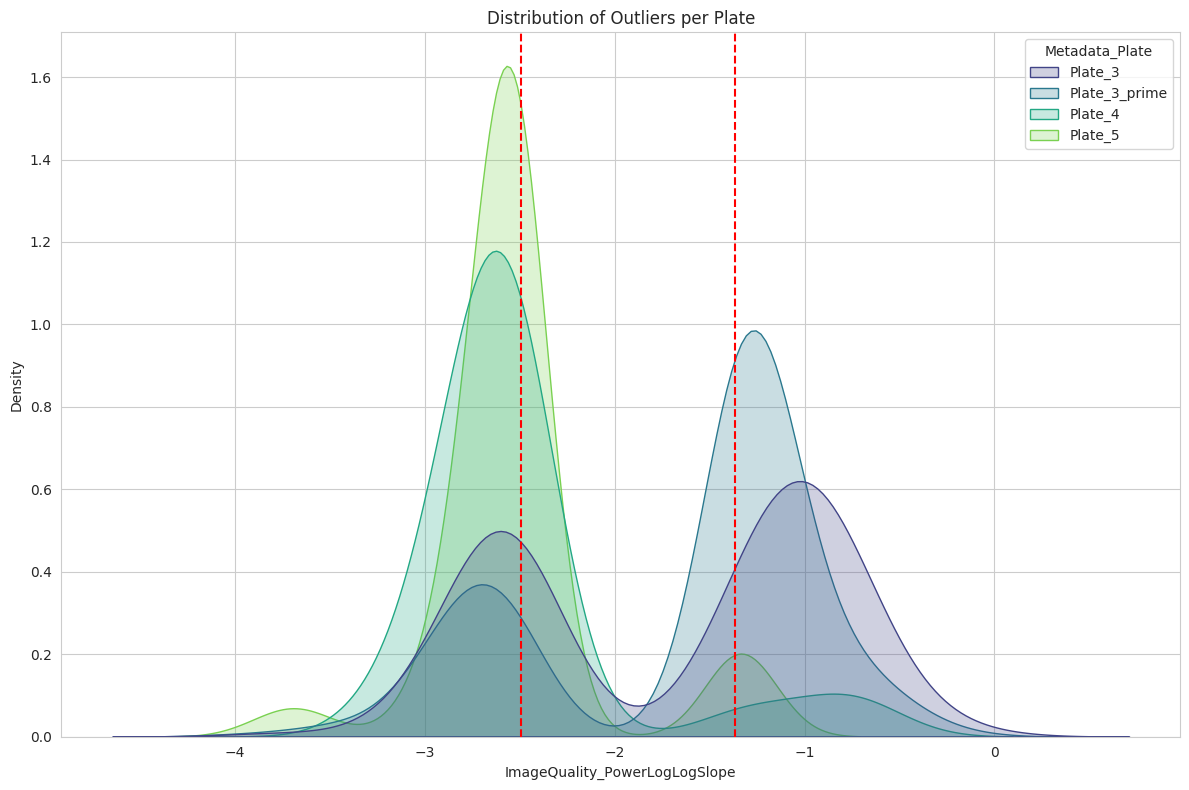

In [9]:
# Plot outliers as a distribution plot with hue as 'Metadata_Plate'
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Using kdeplot (you can also use distplot)
sns.kdeplot(
    data=blur_outliers,
    x="ImageQuality_PowerLogLogSlope",
    hue="Metadata_Plate",
    palette="viridis", 
    fill=True,
    common_norm=False,
)

# Set vertical lines at -2.5 and 1.25
plt.axvline(x=threshold_value_above_mean, color="red", linestyle="--")
plt.axvline(x=threshold_value_below_mean, color="red", linestyle="--")

plt.title("Distribution of Outliers per Plate")
plt.xlabel("ImageQuality_PowerLogLogSlope")

plt.tight_layout()

plt.savefig(figure_dir / "blur_outliers_per_plate.png", dpi=500)

plt.show()

## Saturation metric

For saturation metrics, we are looking for:

- Smudged images or images containing large artifacts (usually seen in `DNA` channel regardless of stain)
- Overly saturated channels which can occur in any channel, but specifically we are seeing `Mito` having the most problems with this.

This means that we will be setting a threshold for outliers for all channels just like for blur. There will be only one threshold for images that are above the mean (**2 standard deviations**) since we are trying to remove over-saturated or images contain artifacts.

In [10]:
summary_statistics = df["ImageQuality_PercentMaximal"].describe()
print(summary_statistics)

count    26448.000000
mean         0.164823
std          0.618692
min          0.000090
25%          0.003434
50%          0.026118
75%          0.117126
max         44.787238
Name: ImageQuality_PercentMaximal, dtype: float64


### Visualize density plot of saturation metric

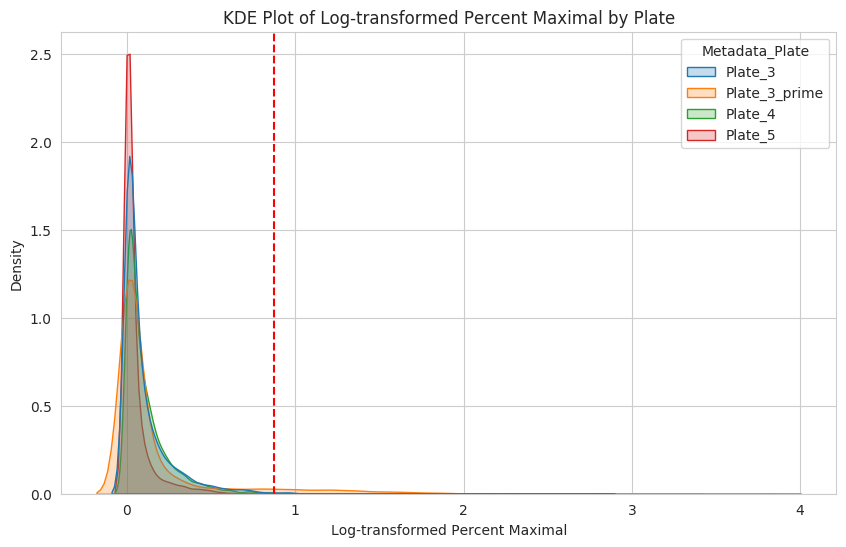

In [11]:
# Create a KDE plot with separate lines for each Metadata_Plate
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=np.log1p(df["ImageQuality_PercentMaximal"]), hue=df["Metadata_Plate"], fill=True
)

# Add a vertical line at the log-transformed value of 1.4
plt.axvline(x=np.log1p(1.4), color='red', linestyle='--', label='Log-transformed 1.4')

# Set labels and title
plt.ylabel("Density")
plt.xlabel("Log-transformed Percent Maximal")
plt.title("KDE Plot of Log-transformed Percent Maximal by Plate")

plt.savefig(figure_dir / "saturation_outliers_per_plate.png", dpi=500)

# Show the plot
plt.show()

### Use z-score to find outliers 2 standard deviations above the mean to view as a data frame

In [12]:
# Calculate Z-scores for the column
z_scores = zscore(df["ImageQuality_PercentMaximal"])

# Set a threshold for Z-scores (adjust as needed for number of standard deviations away from the mean)
threshold_z = 2

# Identify outlier rows based on Z-scores greater than as to identify whole images with abnormally high saturated pixels
saturation_outliers = df[abs(z_scores) > threshold_z]

# Identify unique well + site combos among outliers
unique_combos = saturation_outliers[
    ["Metadata_Well", "Metadata_Site"]
].drop_duplicates()

# Visualize example images through FIJI using data frame identifying outliers
print(saturation_outliers["Channel"].value_counts())
saturation_outliers.sort_values(by="ImageQuality_PercentMaximal", ascending=True).head()

Channel
CY5     521
DAPI     54
RFP       5
GFP       1
Name: count, dtype: int64


,Metadata_Frame,Metadata_Series,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel,Metadata_Plate
21810,0,0,B4,9,-1.673757,1.402716,CY5,Plate_3_prime
20867,0,0,E3,16,-2.072187,1.409043,CY5,Plate_3
24434,0,0,E9,8,-2.118662,1.413290,CY5,Plate_4
22574,0,0,E11,22,-1.846556,1.414284,CY5,Plate_3_prime
22220,0,0,C9,19,-2.302602,1.414284,CY5,Plate_3_prime


### Identify threshold values to use to find outliers above the mean

**Note:** This value will be used in CellProfiler to flag and not process images. We will round to the second decimal to use in the pipeline.

In [13]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PercentMaximal"].mean()
std_dev = df["ImageQuality_PercentMaximal"].std()

# Set the threshold multiplier for above the mean
threshold = 2

# Calculate the threshold values
threshold_value_above_mean = mean_value + threshold * std_dev

# Print the calculated threshold values
print("Threshold for outliers above the mean:", threshold_value_above_mean)

Threshold for outliers above the mean: 1.4022065573415774


**We will be using 1.40 as the threshold for anything that `above` this is considered a outlier for all channels.**